In [1]:
import numpy as np
import matplotlib.pyplot as plt
from models_vector import mcmc_sampler, hmc_sampler, leapfrog_sampler
import jax
import jax.numpy as jnp
import jax.scipy.stats as jst
import seaborn as sns

root_seed=123875938745

2023-03-14 16:44:42.766372: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 16:44:42.795827: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-14 16:44:42.797024: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## MCMC, what's the effect of not discarding samples?

## Multivariate gaussian

### 2D gaussian

In [27]:
dim = 2
mu = np.zeros(dim)
diag = np.linspace(1/dim,1,dim) # stds
cov = np.diag(diag**2) # std is the square root of the eigenvalues of cov
gaussian = lambda x: jst.multivariate_normal.pdf(x, mu, cov)
U = lambda x: -jst.multivariate_normal.logpdf(x, mu, cov)
num_walkers=1
num_samples=5000
step_size = np.min(diag) # chosen to match smallest std
num_steps = (1.5*np.ceil(np.max(diag)/step_size)).astype(int) # effective distance covered is ~num_steps for HMC and ~sqrt(num_steps) MCMC
print(step_size, num_steps)
print(cov)


0.5 3
[[0.25 0.  ]
 [0.   1.  ]]


In [28]:
mcmc_samples, mcmc_trajectories, mcmc_mean, mcmc_mean_std, mcmc_a_rate = mcmc_sampler(gaussian, dim, num_walkers, num_samples, root_seed, step_size=step_size, burn=100)

print(f"\nMCMC acceptance rate {mcmc_a_rate}")
print(f"MCMC estimated expectation: {mcmc_mean[-1]} +/- {mcmc_mean_std[-1]}")

 iter: 499
MCMC acceptance rate 0.6534
MCMC estimated expectation: [-0.00098332 -0.05378558] +/- [0.01684492 0.12588673]


In [32]:
bad_hmc_samples, bad_hmc_trajectories, bad_hmc_mean, bad_hmc_mean_std, bad_hmc_a_rate = hmc_sampler(U, dim, num_walkers, num_samples, root_seed, step_size=step_size, num_steps=num_steps, burn=10)

print(f"\nbad HMC acceptance rate {bad_hmc_a_rate}")
print(f"bad HMC estimated expectation: {bad_hmc_mean[-1]} +/- {bad_hmc_mean_std[-1]}")

 iter: 499
bad HMC acceptance rate 0.8144000172615051
bad HMC estimated expectation: [ 0.00746826 -0.00489893] +/- [0.0255745  0.07817206]


In [30]:
step_size = [0.9*step_size, 1.1*step_size]

hmc_samples, hmc_trajectories, hmc_mean, hmc_mean_std, hmc_a_rate = hmc_sampler(U, dim, num_walkers, num_samples, root_seed, step_size=step_size, num_steps=num_steps, burn=10)

print(f"\nHMC acceptance rate {hmc_a_rate}")
print(f"HMC estimated expectation: {hmc_mean[-1]} +/- {hmc_mean_std[-1]}")

 iter: 499
HMC acceptance rate 0.8144000172615051
HMC estimated expectation: [ 0.00746826 -0.00489893] +/- [0.0255745  0.07817206]


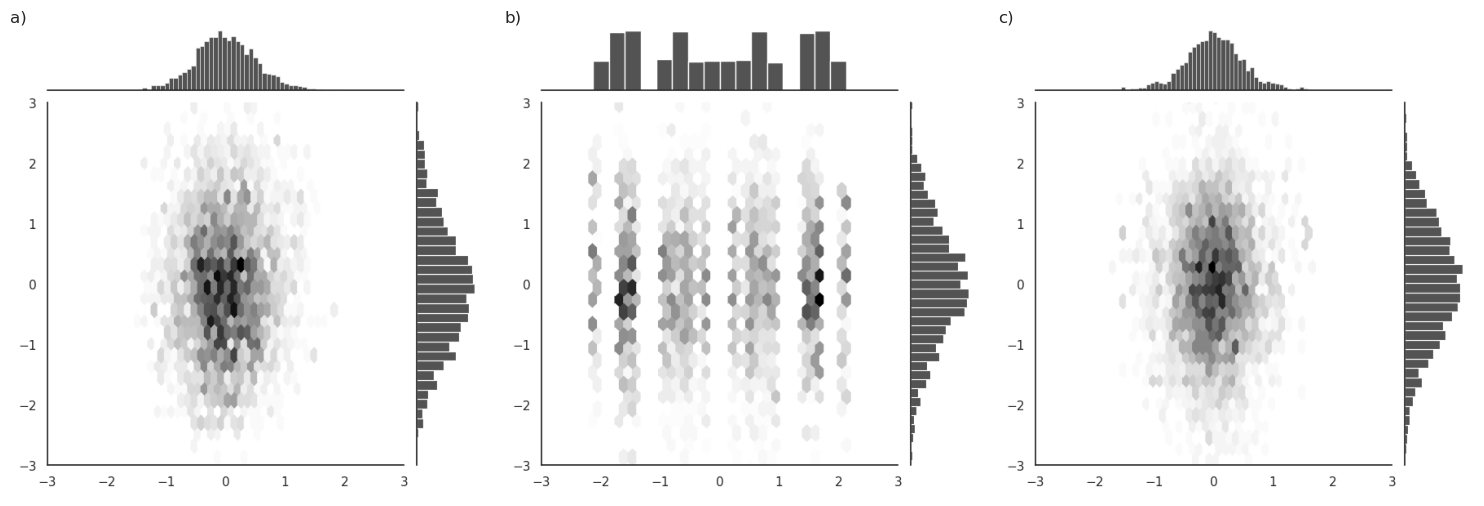

In [31]:
import matplotlib.image as mpimg
letters = "abcdefghijklmnopqrstuvwxyz"

x_lim = [-3, 3]
y_lim = [-3, 3]
sns.set_theme(style="white")

sns.jointplot(x=mcmc_samples[:,0], y=mcmc_samples[:,1], xlim=x_lim, ylim=y_lim, gridsize=30, kind="hex", color="k").savefig('g0.png')
plt.close()
sns.jointplot(x=bad_hmc_samples[:,0], y=bad_hmc_samples[:,1], xlim=x_lim, ylim=y_lim, kind="hex", color="k").savefig('g1.png')
plt.close()
sns.jointplot(x=hmc_samples[:,0], y=hmc_samples[:,1], xlim=x_lim, ylim=y_lim, gridsize=30, kind="hex", color="k").savefig('g2.png')
plt.close()

f, axes = plt.subplots(1, 3, figsize=(15, 7))

for i,ax in enumerate(axes):
    ax.imshow(mpimg.imread(f'g{i}.png'))
    ax.set_axis_off() 
    ax.annotate(f"{letters[i]})",(.1,.1)) # unicode for a) b) c)
plt.tight_layout()

- The variance of the MCMC compared to HMC is smaller in the first dimension but larger in the second, that shows inefficiency of MCMC to explore the regions along dimensions with large variance
- Let's increase the MCMC step size to now match the highest correlation

 iter: 2999
MCMC acceptance rate 0.3975666666666667
MCMC estimated expectation: [ 0.00063008 -0.00121787] +/- [0.00777114 0.04537664]


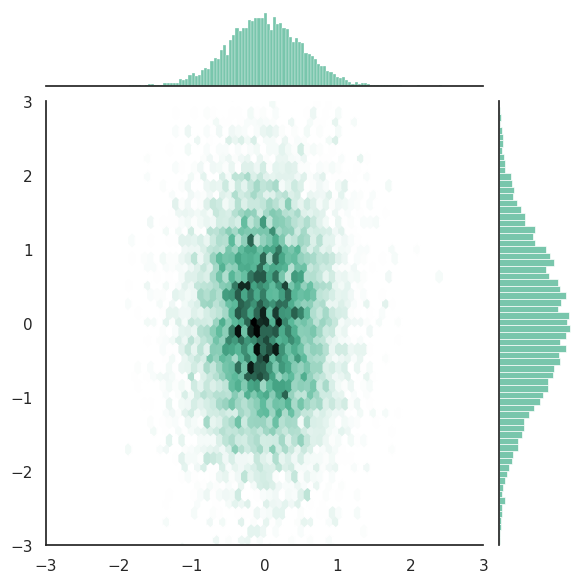

In [117]:
step_size = np.max(diag) 

mcmc_samples, mcmc_trajectories, mcmc_mean, mcmc_mean_std, mcmc_a_rate = mcmc_sampler(gaussian, dim, num_walkers, num_steps*num_samples, root_seed, step_size=step_size)

print(f"\nMCMC acceptance rate {mcmc_a_rate}")
print(f"MCMC estimated expectation: {mcmc_mean[-1]} +/- {mcmc_mean_std[-1]}")

sns.jointplot(x=mcmc_samples[:,0], y=mcmc_samples[:,1], xlim=x_lim, ylim=y_lim, kind="hex", color="#4CB391")

### Autocorrelation

## 100-dimensional gaussian

Remake of the experiment from (Neal)

In [11]:
# Define the pdf and the potential energy function
dim = 100
mu = np.zeros(dim)
diag = np.linspace(1/dim,1,dim) # stds
cov = np.diag(diag**2) # std is the square root of the eigenvalues of cov
gaussian = lambda x: jst.multivariate_normal.pdf(x, mu, cov)
U = lambda x: -jst.multivariate_normal.logpdf(x, mu, cov)
num_walkers=1
num_samples=1000
step_size = np.min(diag) # chosen to match smallest std
num_steps = (1.5*np.ceil(np.max(diag)/step_size)).astype(int) # effective distance covered is ~num_steps for HMC and ~sqrt(num_steps) MCMC
print(num_steps, step_size)

# From Neal
# num_steps = 150
hmc_step_size = [0.0104, 0.0156] # range to sample from
mcmc_step_size = [0.0176, 0.0264]

150 0.01


In [12]:
mcmc_samples, mcmc_trajectories, mcmc_mean, mcmc_mean_std, mcmc_a_rate = mcmc_sampler(gaussian, dim, num_walkers, num_steps*num_samples, root_seed, step_size=mcmc_step_size, burn=0)

print(f"\nMCMC acceptance rate {mcmc_a_rate}")

 iter: 149999
MCMC acceptance rate 0.24773333333333333


In [15]:
from jax import jit
hmc_sampler_cpu = jit(hmc_sampler, backend='cpu')
hmc_sampler_gpu = jit(hmc_sampler, backend='gpu')

hmc_samples, hmc_trajectories, hmc_mean, hmc_mean_std, hmc_a_rate = hmc_sampler(U, dim, num_walkers, num_samples, root_seed, step_size=hmc_step_size, num_steps=num_steps, burn=0)


print(f"HMC acceptance rate {hmc_a_rate}")

 iter: 999HMC acceptance rate 0.6610000133514404


Text(144.5, 0.5, 'HMC')

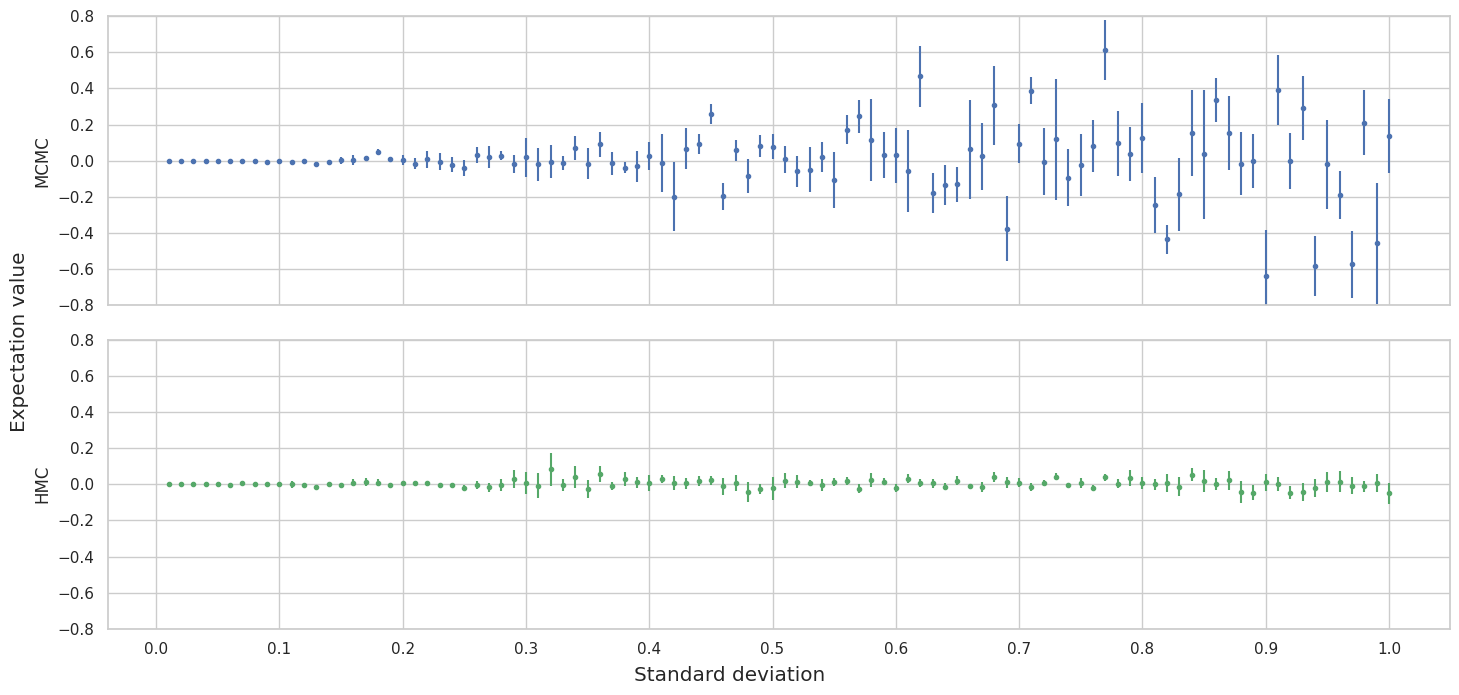

In [83]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(2,1, sharex=True, figsize=(15,7))
fig.supxlabel('Standard deviation')
fig.supylabel('Expectation value')
fig.tight_layout()
fig.subplots_adjust(left=.085)
fig.subplots_adjust(bottom=.09)
# gs = fig.add_gridspec(2, 1)
# fig.add_subplot(gs[1])
for ax in axes:
    # ax.xaxis.grid(False)
    ax.set_ylim(-.8,.8)
    ax.set_xticks(np.linspace(0,1,11))
axes[0].errorbar(diag, mcmc_mean[-1], mcmc_mean_std[-1], fmt=".")
axes[0].set_ylabel("MCMC")
axes[1].errorbar(diag, hmc_mean[-1], hmc_mean_std[-1], c='g', fmt=".")
axes[1].set_ylabel("HMC")


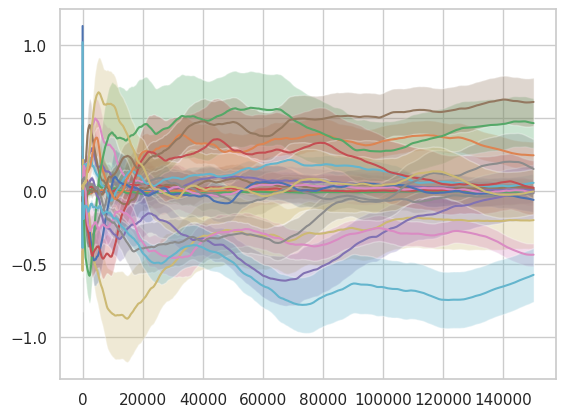

In [74]:
for i in np.arange(1,dim,5):
    plt.plot(hmc_mean[:,i])
    plt.fill_between(np.arange(len(hmc_mean_std)), hmc_mean[:,i]-hmc_mean_std[:,i], hmc_mean[:,i]+hmc_mean_std[:,i], alpha=0.3)

for i in np.arange(1,dim,5):
    plt.plot(mcmc_mean[:,i])
    plt.fill_between(np.arange(len(mcmc_mean_std)), mcmc_mean[:,i]-mcmc_mean_std[:,i], mcmc_mean[:,i]+mcmc_mean_std[:,i], alpha=0.3)

In [79]:
with open(f'hmc_dim{dim}_{num_walkers}walkers_{num_samples}samples.npz', 'wb') as f:
    np.savez(f, hmc_samples=hmc_samples,
                hmc_trajectories=hmc_trajectories,
                hmc_mean=hmc_mean,
                hmc_mean_std=hmc_mean_std,
                hmc_a_rate=hmc_a_rate)

with open(f'mcmc_dim{dim}_{num_walkers}walkers_{num_samples}samples.npz', 'wb') as f:
    np.savez(f, mcmc_samples=mcmc_samples,
                mcmc_trajectories=mcmc_trajectories,
                mcmc_mean=mcmc_mean,
                mcmc_mean_std=mcmc_mean_std,
                mcmc_a_rate=mcmc_a_rate)

In [85]:
with np.load('hmc_dim100_1walkers_1000samples.npz', 'rb') as hmc:
    print(f"Acceptance rate: {hmc['hmc_a_rate']}")

with np.load('mcmc_dim100_1walkers_1000samples.npz', 'rb') as mcmc:
    print(f"Acceptance rate: {mcmc['mcmc_a_rate']}")



Acceptance rate: 0.6610000133514404
Acceptance rate: 0.24773333333333333


investigate what happens when you start at 0 but the distribution is not at zero

## Mass influence

### Leapfrog for various masses in a funnel